#### Analysis of multiple stocks - for simulation over the course of n years at variable buy in frequency

Goal: This script simulates any number (typically 2) years of n-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through a series of overlapping cycles of variable length, creating a linear prediction to be applied. Assess the theoretical performance of adjusting contributions as compared to contributing a consistent amount over time.


In [425]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
from sys import exit

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [426]:
# ## doing
# any areas where defined functions can be used to good effect?
# assn more descriptive variable, list names
#     invest every monday, invest every other monday, etc
# Clean up code

# ## To do
# swap to open price insteal of close - it's closer to actual pratice
# fix the copy errors - do it right
# I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
#     I need to pick a series of random stocks and see if I still beat baseline
# fix the copy warnings

# ## bigger changes that might warrant a new doc entirely
# be able to do any unit of time, not just days - make it 'units' of time
#     so I can check on hypothetical minute to minute trading
# Start testing buy/sell every period based on a set budget
#     will likely be a big job. maybe a lot of changes needed
#     will possibly need to make it it's own script
#     I do still want to compare to a standard buy and hold consistently approach as the baseline

# ## Fixed
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
#     seems to have an issue with the reversal of percents when the total profits are negative
#     need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
#     I can't actually trust this method until I do this
#     probably means actually using time series instead of the index replacement -- nope
# be able to run on SP500
#     SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
# error checking on too much history run
#     have a whole section dedicated to it and say which stock and by how much it misses
# Make a path to DL data and call to it again w/o issues
#     For flights w/o internet
# be able to do one stock at a time -- OR be able to bypass
# 3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
# test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
#     invest_weeks must be an integer
#     re-check all new facets of weeks and invest_weeks
# convert 'y' years of data to be 'w?' weeks.
#     calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
# make the invest period dynamic
# make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix




In [427]:
##### User choices go here #####

# choose stocks of interest
# stocks chosen must all have data for full range of dates
stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MDB', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
# stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SQ', 'TSM']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['AAPL']
# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['OSBC', 'MZZ', 'AEPPL', 'LDOS', 'AXU', 'ACM', 'MIND', 'PESI', 'JBT', 'FMN', ] # randomly pulled stocks

# choose how much to contribute each weekly period
contrib_amt = 10

# weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

# invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 2

# number of days to roll into each linear regression.
# 260 will be about 1 year
# 65 will be about 1 quarter
# 21 will be about 1 month
# remember, a trading week is a bit less than 5 days on average
roll_days = 65

# opt 5 threshold of consistent buying vs increased buying
buyvalue = 1.2

# if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/close2 * multiplier)
multiplier = 3

##### choices on the fence, maybe they should be actively chosen #####

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
invest = 10000
# invest = contrib_amt*invest_weeks
print('Total invest amount over', total_weeks, 'weeks:', invest)


##### 'choices' that should really be left alone #####

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)
print('Number of invest weeks:', invest_weeks)

# number of years to visualize
day_hist = (total_weeks*5)+roll_days+1 # *5 because a trading week is 5 days or less
print('Days of data to pull:', day_hist)



Total invest amount over 104 weeks: 10000
Number of invest weeks: 52
Days of data to pull: 586


In [428]:
# Pull the data
df = yf.download(
        tickers = stock_list
        ,period = str(day_hist) + 'd'
        #,start = '2017-02-14' # to choose custom date ranges
        #,end = '2020-02-14' # to choose custom date ranges
    )

# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Close']
    df = df[[stock_list[0]]]
else:
    df = df['Close']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

df

[*********************100%***********************]  14 of 14 completed
No stock history issues seen


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,,,,,,,,
2019-09-24,54.419998,29.520000,1741.609985,152.050003,1218.760010,49.820000,124.019997,137.380005,43.132500,187.970001,89.919998,57.500000,44.641998,44.119999,1,2019-09-24,1,1,0
2019-09-25,55.257500,29.540001,1768.329956,152.990005,1246.520020,51.020000,125.000000,139.360001,44.557499,190.080002,90.349998,58.509998,45.740002,45.009998,2,2019-09-25,2,1,0
2019-09-26,54.972500,29.469999,1739.839966,152.339996,1241.390015,50.919998,126.660004,139.539993,44.334999,189.380005,89.800003,60.799999,48.512001,46.459999,3,2019-09-26,3,1,0
2019-09-27,54.705002,28.719999,1725.449951,148.259995,1225.089966,50.779999,117.330002,137.729996,42.939999,187.029999,88.370003,60.750000,48.425999,45.509998,4,2019-09-27,4,1,0
2019-09-30,55.992500,28.990000,1735.910034,148.440002,1219.000000,51.529999,120.480003,139.029999,43.517502,188.809998,88.419998,61.950001,48.174000,46.480000,5,2019-09-30,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-12,175.529999,137.470001,3304.139893,237.830002,2832.959961,55.740002,432.489990,318.269989,279.989990,387.350006,103.870003,145.470001,1106.219971,132.229996,582,2022-01-12,2,121,0
2022-01-13,172.190002,132.740005,3224.280029,228.630005,2782.620117,54.939999,390.829987,304.799988,265.750000,377.660004,102.400002,136.949997,1031.560059,139.190002,583,2022-01-13,3,121,0
2022-01-14,173.070007,136.880005,3242.760010,231.229996,2795.729980,55.700001,396.890015,310.200012,269.420013,380.010010,100.120003,133.289993,1049.609985,140.660004,584,2022-01-14,4,121,0


In [429]:
# export raw data for offline use

# df.to_csv(r'/Users/james.applewhite/Desktop/python_desktop/rand10_20211226.csv', index = False)
# df.to_csv(r'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/offline_source_20211219.csv', index = False)
# df.to_csv(r'/Volumes/Google Drive/My Drive/Python/other_projects/offline_source_20211220.csv', index = False)

In [430]:
# import saved data

# df = pd.read_csv (r'/Users/james.applewhite/Desktop/python_desktop/sp500_2year_2week_20211223.csv')
# df = pd.read_csv (r'/Users/james.applewhite/Desktop/python_desktop/offline_source_20211223.csv')
# df = pd.read_csv (r'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/offline_source_20211219.csv')
# df = pd.read_csv (r'/Volumes/Google Drive/My Drive/Python/other_projects/offline_source_20211220.csv')
# df

In [431]:
# make a list of indices that are the Mondays where the trade should take place
# always starting with the most recent Monday

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[585, 575, 566, 556, 547, 537, 527, 517, 507, 497, 488, 478, 468, 458, 449, 439, 429, 420, 410, 400, 390, 381, 371, 361, 352, 342, 333, 323, 315, 305, 296, 286, 276, 266, 256, 246, 237, 227, 217, 207, 197, 188, 178, 169, 159, 149, 139, 130, 120, 110, 101, 91]
Number of weeks picked: 52


In [432]:
# create 1 dataframe per invest week in a dictionary, each the length of the chosen invest period
# 0 is the most recent

dataframes = {}

for j in stock_list:
    for i in range(invest_weeks):
        x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
        y = nth_wk[i]

        dataframes['data' + str(i)] = df.iloc[x:y]

print(dataframes['data0'])
print(dataframes['data' + str(invest_weeks-1)])

                  AAPL         AMD         AMZN         CRM         GOOG  \
Date                                                                       
2021-10-15  144.839996  112.120003  3409.020020  291.660004  2833.500000   
2021-10-18  146.550003  116.430000  3446.739990  291.700012  2859.209961   
2021-10-19  148.759995  116.330002  3444.149902  292.339996  2876.439941   
2021-10-20  149.259995  116.389999  3415.060059  290.089996  2848.300049   
2021-10-21  149.479996  119.330002  3435.010010  289.809998  2855.610107   
...                ...         ...          ...         ...          ...   
2022-01-11  175.080002  137.309998  3307.239990  234.839996  2800.350098   
2022-01-12  175.529999  137.470001  3304.139893  237.830002  2832.959961   
2022-01-13  172.190002  132.740005  3224.280029  228.630005  2782.620117   
2022-01-14  173.070007  136.880005  3242.760010  231.229996  2795.729980   
2022-01-18  169.800003  131.929993  3178.350098  226.059998  2725.810059   

           

In [433]:
len(dataframes)

52

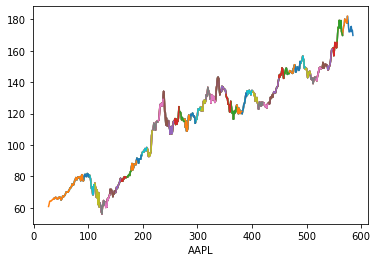

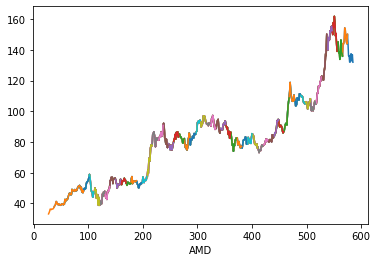

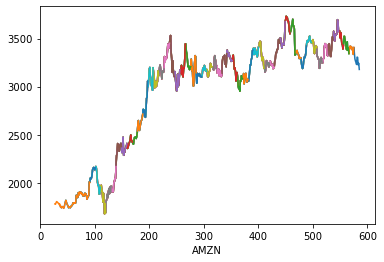

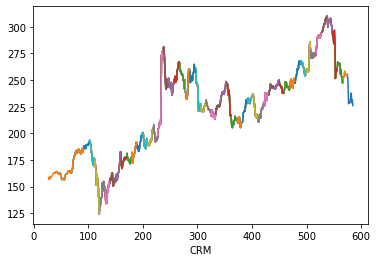

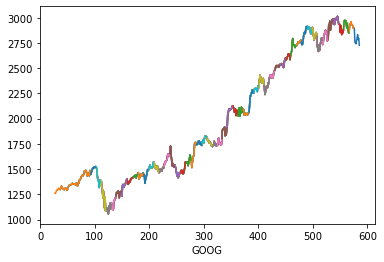

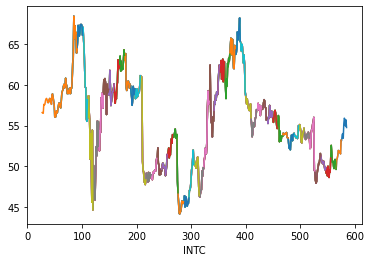

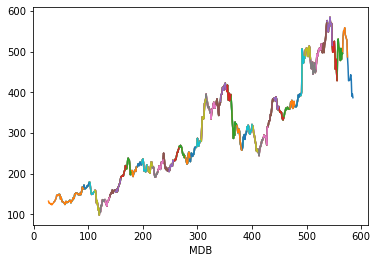

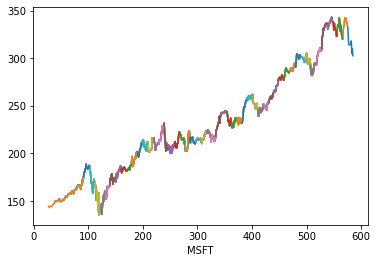

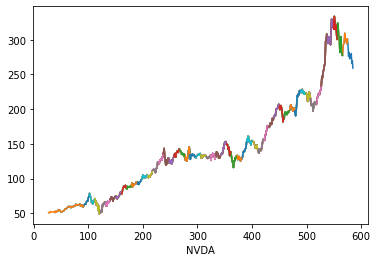

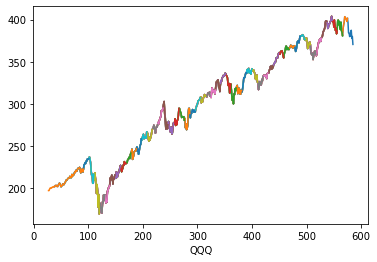

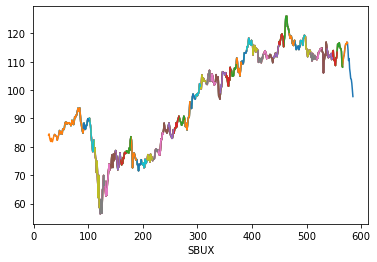

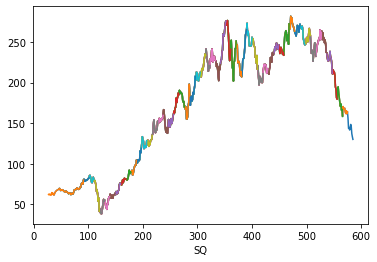

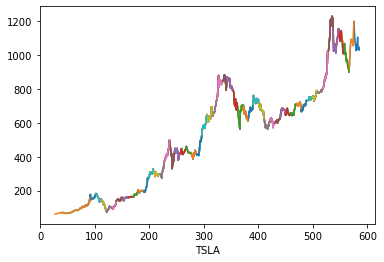

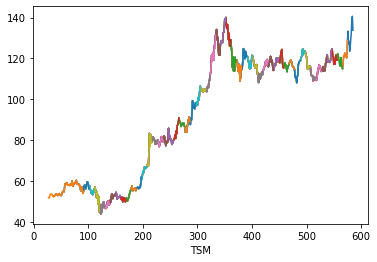

In [434]:
# shows each investing period, overlapping
### meh, less useful if I can't account for the dynamic investing periods

for i in stock_list:
    for j in range(len(dataframes)):
        # plot data with a trendline - the middle 260 days
        x = dataframes['data' + str(j)]['Index']
        y = dataframes['data' + str(j)][str(i)]
        plt.plot(x, y)
        # m, b = np.polyfit(x, y, 1)
        # plt.plot(x, m*x + b)

    plt.xlabel(i)
    plt.show()

In [435]:
# raw prices for the pulled period of days

# for i in stock_list:
#     x = df['Index']
#     y = df[str(i)]
#     plt.plot(x, y)

#     plt.xlabel(i)
#     plt.show()

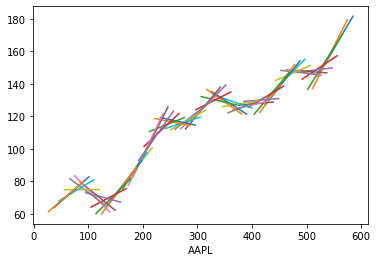

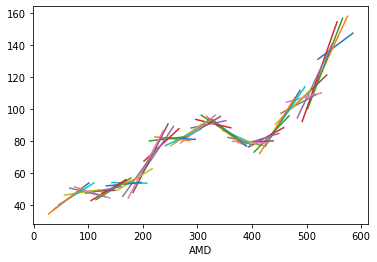

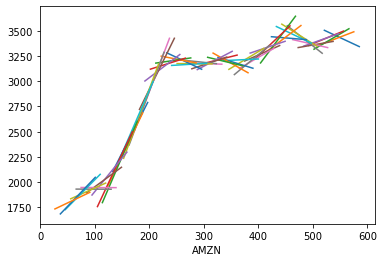

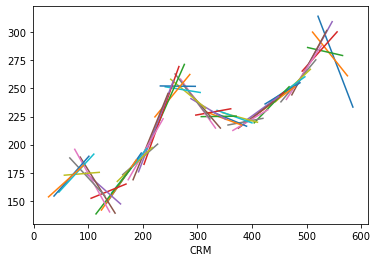

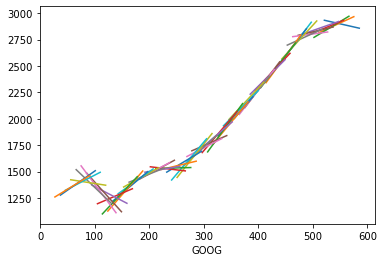

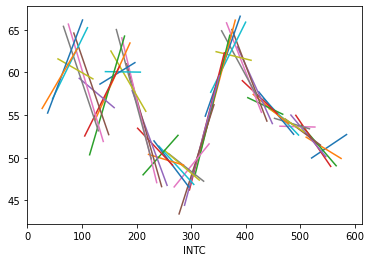

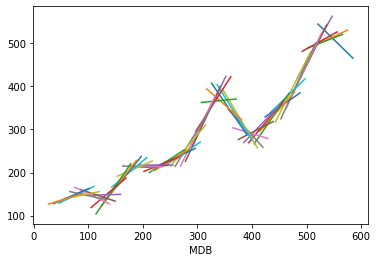

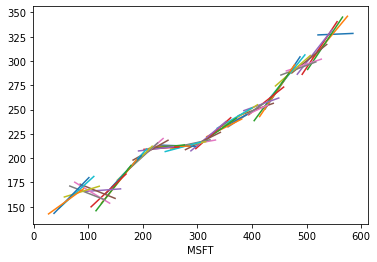

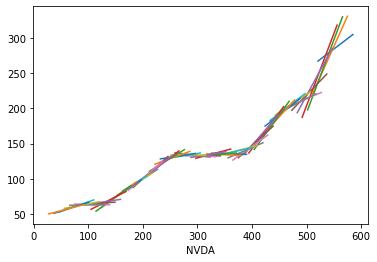

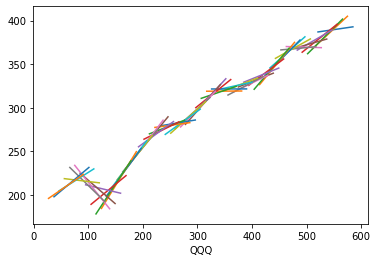

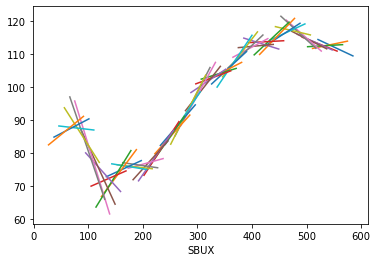

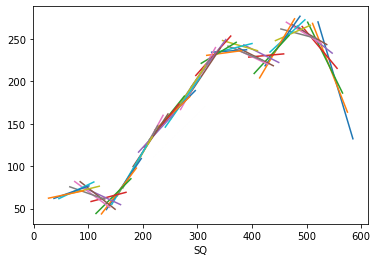

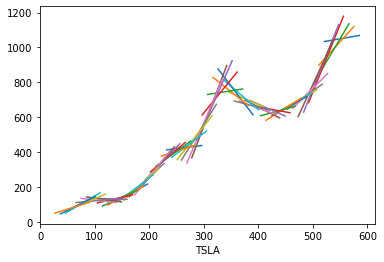

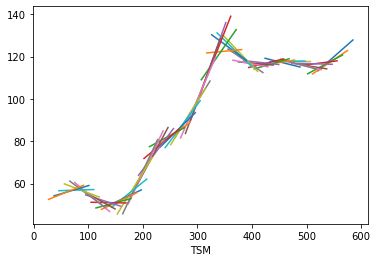

In [436]:
# plot only trendlines, every n weeks, each line representing the chosen length of data
# if the movement is too stable, these graphs won't be useable

for j in stock_list:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [437]:
########## IP
########## redo it - I don't need to run a linear regression for every day in the period
########## I just need a linear regression on the last day

# for j in stock_list:
#     for e in range(len(dataframes)):
#         nlist = []
#         ylist = []
#         y = dataframes['data' + str(e)][str(j)]

#         x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
#         m, b = np.polyfit(x, y, 1)
#         d = m*i+b
#         nlist.append(d)

#         dataframes['data' + str(e)][str(j) + ' pred'] = nlist


#         # for i in range(1,len(dataframes['data0'])+1): # create pred/close
#         #     d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
#         #     ylist.append(d)

#         # dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist


# dataframes['data0'] # just the most recent segment

In [438]:
# create pred and pred/close list for each of the n dataframes
# may take 30+ seconds to run

for j in stock_list:
    for e in range(len(dataframes)):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
            m, b = np.polyfit(x, y, 1)
            d = m*i+b
            nlist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/close
            d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
            ylist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist

dataframes['data0'] # just the most recent segment

<ipython-input-438-9b627f205eac>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
<ipython-input-438-9b627f205eac>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,...,QQQ pred,QQQ pred/close,SBUX pred,SBUX pred/close,SQ pred,SQ pred/close,TSLA pred,TSLA pred/close,TSM pred,TSM pred/close
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-15,144.839996,112.120003,3409.020020,291.660004,2833.500000,54.459999,491.809998,304.209991,218.619995,368.940002,...,386.907133,1.048699,114.408140,1.026542,269.909945,1.083976,1034.095735,1.226642,113.273091,0.986184
2021-10-18,146.550003,116.430000,3446.739990,291.700012,2859.209961,54.470001,503.959991,307.290009,222.220001,372.649994,...,386.998655,1.038504,114.330569,1.008473,267.758538,1.061691,1034.635118,1.189085,113.500389,0.984051
2021-10-19,148.759995,116.330002,3444.149902,292.339996,2876.439941,55.209999,508.010010,308.230011,222.899994,375.470001,...,387.090177,1.030948,114.252997,1.006723,265.607131,1.044012,1035.174502,1.197744,113.727686,0.972364
2021-10-20,149.259995,116.389999,3415.060059,290.089996,2848.300049,55.369999,504.500000,307.410004,221.029999,374.980011,...,387.181699,1.032540,114.175425,1.002770,263.455724,1.031744,1035.713885,1.196251,113.954984,0.985855
2021-10-21,149.479996,119.330002,3435.010010,289.809998,2855.610107,56.000000,509.429993,310.760010,226.919998,377.269989,...,387.273222,1.026515,114.097854,0.997010,261.304317,0.985756,1036.253268,1.159120,114.182282,0.981875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-11,175.080002,137.309998,3307.239990,234.839996,2800.350098,55.910000,443.790009,314.980011,278.170013,385.820007,...,392.398471,1.017051,109.753839,1.054920,140.825529,0.948767,1066.458725,1.001934,126.910949,0.982511
2022-01-12,175.529999,137.470001,3304.139893,237.830002,2832.959961,55.740002,432.489990,318.269989,279.989990,387.350006,...,392.489993,1.013270,109.676268,1.055899,138.674122,0.953283,1066.998108,0.964544,127.138247,0.961493
2022-01-13,172.190002,132.740005,3224.280029,228.630005,2782.620117,54.939999,390.829987,304.799988,265.750000,377.660004,...,392.581516,1.039510,109.598696,1.070300,136.522715,0.996880,1067.537491,1.034877,127.365545,0.915048


In [439]:
# pull the last 'close' and pred/close' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last close price in a given period and the final pred/close derived from the linear trendline

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []

    for e in reversed(range(len(dataframes))):
        nlist.append(dataframes['data' + str(e)][str(j) + ' pred/close'].iloc[roll_days-1])
        ylist.append(dataframes['data' + str(e)][str(j)].iloc[roll_days-1])
        zlist.append(dataframes['data' + str(e)][str(j) + ' pred'].iloc[roll_days-1])

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/close'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,SBUX pred/close,SQ,SQ pred,SQ pred/close,TSLA,TSLA pred,TSLA pred/close,TSM,TSM pred,TSM pred/close
42,43,149.550003,155.289245,1.038377,104.800003,114.016042,1.087939,3457.169922,3376.952066,0.976797,...,0.999526,246.679993,272.413049,1.104318,743.000000,738.223433,0.993571,123.620003,117.856447,0.953377
43,44,145.369995,151.361971,1.041219,108.160004,112.128462,1.036691,3405.800049,3347.012832,0.982739,...,1.018660,258.109985,265.963635,1.030428,791.359985,757.341269,0.957012,116.150002,117.648755,1.012904
44,45,142.809998,145.939174,1.021911,104.680000,109.057747,1.041820,3246.300049,3276.436771,1.009283,...,1.007519,232.330002,250.651971,1.078862,791.940002,789.921343,0.997451,110.260002,114.199483,1.035729
45,46,148.639999,145.267200,0.977309,122.360001,110.183525,0.900486,3320.370117,3332.419931,1.003629,...,0.966907,262.000000,244.523398,0.933295,1024.859985,850.986154,0.830344,113.639999,113.797538,1.001386
46,47,150.440002,146.819623,0.975935,150.160004,121.352629,0.808155,3488.979980,3393.454906,0.972621,...,0.968933,236.770004,243.259845,1.027410,1162.939941,1040.322681,0.894563,120.910004,114.181609,0.944352
47,48,161.020004,149.875652,0.930789,152.520004,140.689385,0.922432,3572.570068,3470.039359,0.971301,...,0.998189,211.309998,233.163608,1.103420,1156.869995,1130.925960,0.977574,124.750000,116.326910,0.932480
48,49,165.320007,157.338575,0.951721,139.059998,154.589146,1.111672,3427.370117,3495.643489,1.019920,...,0.978317,179.720001,215.220924,1.197535,1009.010010,1178.636016,1.168111,119.139999,117.956308,0.990065
49,50,169.750000,170.752085,1.005903,135.800003,156.824547,1.154820,3341.580078,3519.004055,1.053096,...,1.044036,158.300003,186.137708,1.175854,899.940002,1135.078460,1.261282,114.940002,120.733147,1.050401
50,51,182.009995,179.611134,0.986820,150.240005,158.115385,1.052419,3408.090088,3488.929489,1.023720,...,0.976269,164.029999,163.604826,0.997408,1199.780029,1119.126539,0.932776,128.800003,122.829147,0.953642
51,52,169.800003,181.669972,1.069906,131.929993,147.521370,1.118179,3178.350098,3342.208811,1.051555,...,1.119856,130.000000,132.219902,1.017076,1030.510010,1068.616258,1.036978,133.830002,127.820140,0.955093


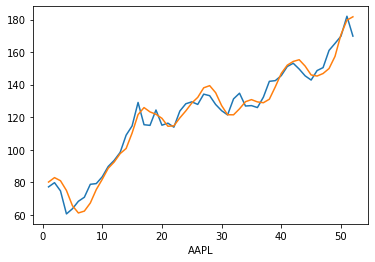

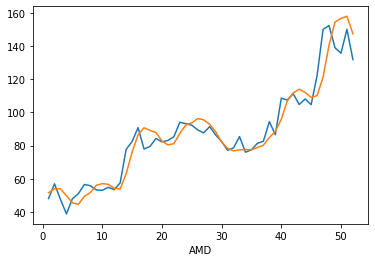

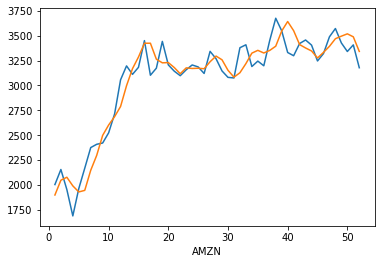

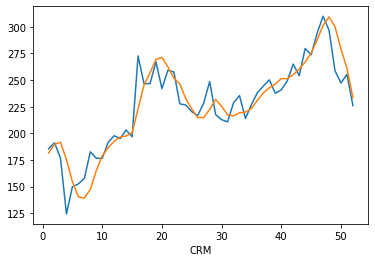

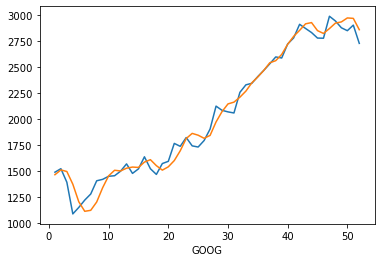

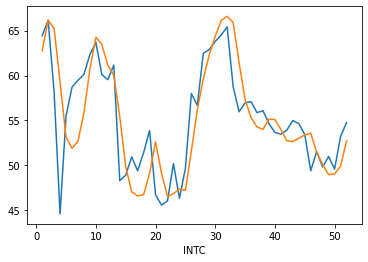

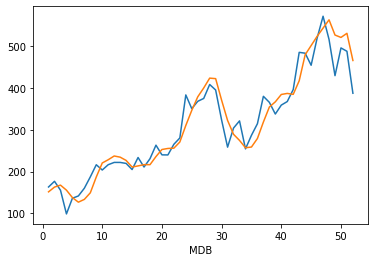

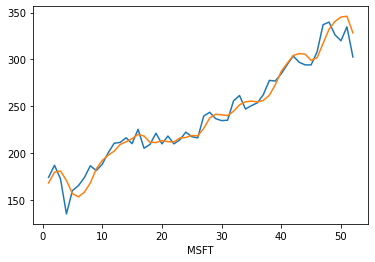

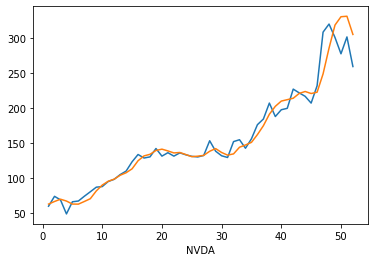

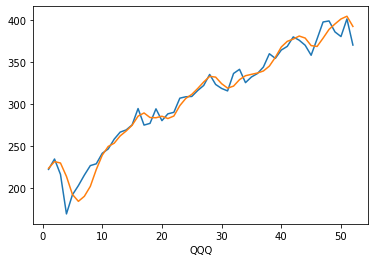

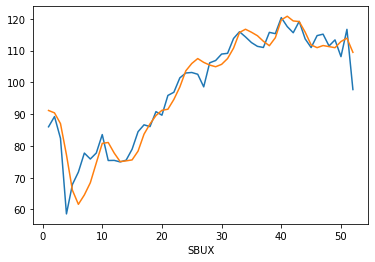

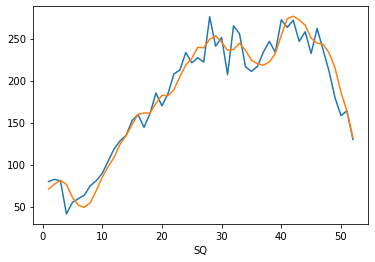

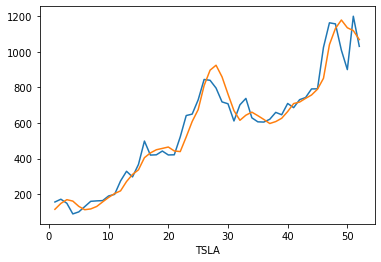

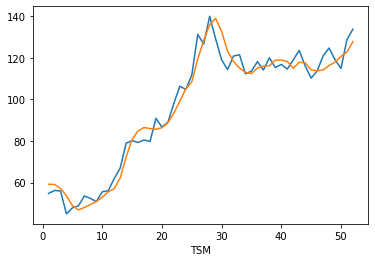

In [440]:
# plot for each stock the close price and the prediction price
# close (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [441]:
# determine the weeks where pred/close is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have close to 0 pred/close > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/close'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG >1,INTC >1,MDB >1,MSFT >1,NVDA >1,QQQ >1,SBUX >1,SQ >1,TSLA >1,TSM >1
42,43,149.550003,155.289245,1.038377,104.800003,114.016042,1.087939,3457.169922,3376.952066,0.976797,...,1,0,0,1,0,1,0,1,0,0
43,44,145.369995,151.361971,1.041219,108.160004,112.128462,1.036691,3405.800049,3347.012832,0.982739,...,1,0,0,1,1,1,1,1,0,1
44,45,142.809998,145.939174,1.021911,104.680000,109.057747,1.041820,3246.300049,3276.436771,1.009283,...,1,0,1,1,1,1,1,1,0,1
45,46,148.639999,145.267200,0.977309,122.360001,110.183525,0.900486,3320.370117,3332.419931,1.003629,...,1,1,1,0,0,0,0,0,0,1
46,47,150.440002,146.819623,0.975935,150.160004,121.352629,0.808155,3488.979980,3393.454906,0.972621,...,0,0,0,0,0,0,0,1,0,0
47,48,161.020004,149.875652,0.930789,152.520004,140.689385,0.922432,3572.570068,3470.039359,0.971301,...,0,1,1,0,0,0,0,1,0,0
48,49,165.320007,157.338575,0.951721,139.059998,154.589146,1.111672,3427.370117,3495.643489,1.019920,...,1,0,1,1,1,1,0,1,1,0
49,50,169.750000,170.752085,1.005903,135.800003,156.824547,1.154820,3341.580078,3519.004055,1.053096,...,1,0,1,1,1,1,1,1,1,1
50,51,182.009995,179.611134,0.986820,150.240005,158.115385,1.052419,3408.090088,3488.929489,1.023720,...,1,0,1,1,1,1,0,0,0,0
51,52,169.800003,181.669972,1.069906,131.929993,147.521370,1.118179,3178.350098,3342.208811,1.051555,...,1,0,1,1,1,1,1,1,1,0


In [442]:
# square the pred/close number as a more extreme option for calculations

for j in stock_list:
    df[str(j) +' pred/close2'] = df[str(j) +' pred/close']**2 # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG pred/close2,INTC pred/close2,MDB pred/close2,MSFT pred/close2,NVDA pred/close2,QQQ pred/close2,SBUX pred/close2,SQ pred/close2,TSLA pred/close2,TSM pred/close2
42,43,149.550003,155.289245,1.038377,104.800003,114.016042,1.087939,3457.169922,3376.952066,0.976797,...,1.031404,0.916885,0.739659,1.063383,0.992832,1.026594,0.999052,1.219517,0.987184,0.908927
43,44,145.369995,151.361971,1.041219,108.160004,112.128462,1.036691,3405.800049,3347.012832,0.982739,...,1.068899,0.941166,0.984584,1.079413,1.064695,1.046684,1.037669,1.061781,0.915873,1.025974
44,45,142.809998,145.939174,1.021911,104.680000,109.057747,1.041820,3246.300049,3276.436771,1.009283,...,1.052235,0.998035,1.217984,1.032675,1.136302,1.065348,1.015094,1.163943,0.994908,1.072735
45,46,148.639999,145.267200,0.977309,122.360001,110.183525,0.900486,3320.370117,3332.419931,1.003629,...,1.033450,1.176587,1.016747,0.959735,0.922146,0.952765,0.934910,0.871040,0.689471,1.002775
46,47,150.440002,146.819623,0.975935,150.160004,121.352629,0.808155,3488.979980,3393.454906,0.972621,...,0.922268,0.997601,0.903283,0.885095,0.650989,0.905367,0.938831,1.055571,0.800242,0.891801
47,48,161.020004,149.875652,0.930789,152.520004,140.689385,0.922432,3572.570068,3470.039359,0.971301,...,0.985976,1.011474,1.190104,0.955727,0.796860,0.950048,0.996381,1.217535,0.955651,0.869519
48,49,165.320007,157.338575,0.951721,139.059998,154.589146,1.111672,3427.370117,3495.643489,1.019920,...,1.039741,0.922498,1.503158,1.089370,1.121649,1.049991,0.957103,1.434089,1.364484,0.980228
49,50,169.750000,170.752085,1.005903,135.800003,156.824547,1.154820,3341.580078,3519.004055,1.053096,...,1.087997,0.978029,1.103705,1.164106,1.417089,1.113068,1.090011,1.382633,1.590833,1.103343
50,51,182.009995,179.611134,0.986820,150.240005,158.115385,1.052419,3408.090088,3488.929489,1.023720,...,1.045370,0.879800,1.183946,1.068526,1.205218,1.016077,0.953101,0.994823,0.870072,0.909434
51,52,169.800003,181.669972,1.069906,131.929993,147.521370,1.118179,3178.350098,3342.208811,1.051555,...,1.098970,0.926602,1.445208,1.177025,1.384192,1.123495,1.254078,1.034444,1.075323,0.912203


In [443]:
# Create all of the strategies to test 

for j in stock_list:
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = contrib_amt
        df[str(j) +' baseline_stk'].iloc[i] = df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt
        if v < contrib_amt:
            break

# opt1 - buy in every other week but proportionally to the pred/close
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = contrib_amt*df[str(j) +' pred/close'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*df[str(j) +' pred/close'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/close
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = contrib_amt*df[str(j) +' pred/close2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*df[str(j) +' pred/close2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*df[str(j) +' pred/close2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = contrib_amt*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/close
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = contrib_amt/df[str(j) +' pred/close'].iloc[i]
        df[str(j) +' opt4_stk'].iloc[i] = df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt/df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt/df[str(j) +' pred/close'].iloc[t]:
            break

# opt5
    df[str(j) +' opt5'] = 0
    df[str(j) +' opt5_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/close2'].iloc[i] < buyvalue:
            df[str(j) +' opt5'].iloc[i] = contrib_amt
        else:
            # df[str(j) +' opt5'].iloc[i] = contrib_amt*df[str(j) +' pred/close2'].iloc[i] 
            df[str(j) +' opt5'].iloc[i] = contrib_amt * df[str(j) +' pred/close2'].iloc[i] * multiplier
        df[str(j) +' opt5_stk'].iloc[i] = df[str(j) +' opt5'].iloc[i]/df[str(j)].iloc[i]
        v -= contrib_amt*df[str(j) +' pred/close2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < contrib_amt*df[str(j) +' pred/close2'].iloc[t]:
            break

df.tail(10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,TSM opt1,TSM opt1_stk,TSM opt2,TSM opt2_stk,TSM opt3,TSM opt3_stk,TSM opt4,TSM opt4_stk,TSM opt5,TSM opt5_stk
42,43,149.550003,155.289245,1.038377,104.800003,114.016042,1.087939,3457.169922,3376.952066,0.976797,...,9.533768,0.077122,9.089274,0.073526,0,0.000000,10.489032,0.084849,10.0,0.080893
43,44,145.369995,151.361971,1.041219,108.160004,112.128462,1.036691,3405.800049,3347.012832,0.982739,...,10.129036,0.087207,10.259737,0.088332,20,0.172191,9.872608,0.084999,10.0,0.086096
44,45,142.809998,145.939174,1.021911,104.680000,109.057747,1.041820,3246.300049,3276.436771,1.009283,...,10.357290,0.093935,10.727346,0.097291,20,0.181389,9.655035,0.087566,10.0,0.090695
45,46,148.639999,145.267200,0.977309,122.360001,110.183525,0.900486,3320.370117,3332.419931,1.003629,...,10.013863,0.088119,10.027745,0.088241,20,0.175994,9.986156,0.087875,10.0,0.087997
46,47,150.440002,146.819623,0.975935,150.160004,121.352629,0.808155,3488.979980,3393.454906,0.972621,...,9.443520,0.078104,8.918008,0.073757,0,0.000000,10.589271,0.087580,10.0,0.082706
47,48,161.020004,149.875652,0.930789,152.520004,140.689385,0.922432,3572.570068,3470.039359,0.971301,...,9.324802,0.074748,8.695194,0.069701,0,0.000000,10.724088,0.085965,10.0,0.080160
48,49,165.320007,157.338575,0.951721,139.059998,154.589146,1.111672,3427.370117,3495.643489,1.019920,...,9.900647,0.083101,9.802281,0.082275,0,0.000000,10.100350,0.084777,10.0,0.083935
49,50,169.750000,170.752085,1.005903,135.800003,156.824547,1.154820,3341.580078,3519.004055,1.053096,...,10.504015,0.091387,11.033432,0.095993,20,0.174004,9.520170,0.082827,10.0,0.087002
50,51,182.009995,179.611134,0.986820,150.240005,158.115385,1.052419,3408.090088,3488.929489,1.023720,...,9.536424,0.074041,9.094339,0.070608,0,0.000000,10.486111,0.081414,10.0,0.077640
51,52,169.800003,181.669972,1.069906,131.929993,147.521370,1.118179,3178.350098,3342.208811,1.051555,...,9.550933,0.071366,9.122032,0.068161,0,0.000000,10.470181,0.078235,10.0,0.074722


In [444]:
df
df.to_csv(f'/Users/james.applewhite/Desktop/test.csv', index = False)

In [445]:
print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')
print('opt5 - normal buy in, boosted at high pred/close')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in stock_list:
    d = {'name': [str(j) +' baseline', str(j) +' opt1', str(j) +' opt2', str(j) +' opt3', str(j) +' opt4', str(j) +' opt5']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2),
             round(sum(df[str(j) +' opt5']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4), 
             round(sum(df[str(j) +' opt5_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt4']),2), 
             round((sum(df[str(j) +' opt5_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt5']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[5] = round(df2['profit'].iloc[5]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable
opt5 - normal buy in, boosted at high pred/close

            name  bought_in  stocks_held  profit   diff  %_diff
0  AAPL baseline     520.00       4.6070  262.27   0.00    0.00
1      AAPL opt1     519.03       4.6067  263.19   0.92    0.35
2      AAPL opt2     519.97       4.6296  266.13   3.86    1.45
3      AAPL opt3     520.00       4.5783  257.40  -4.87   -1.89
4      AAPL opt4     522.84       4.6296  263.27   1.00    0.38
5      AAPL opt5     555.97       5.2010  327.17  64.90   19.84

           name  bought_in  stocks_held  profit    diff  %_diff
0  AMD baseline     520.00       6.6819  361.54    0.00    0.00
1  

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [446]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMD bought_in,AMZN bought_in,CRM bought_in,GOOG bought_in,INTC bought_in,MDB bought_in,MSFT bought_in,NVDA bought_in,QQQ bought_in,SBUX bought_in,SQ bought_in,TSLA bought_in,TSM bought_in
0,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00,520.00
1,519.03,521.44,520.73,522.54,521.43,520.03,526.14,520.44,519.85,520.15,520.54,524.00,516.84,518.25
2,519.97,527.14,522.87,528.96,524.65,523.05,540.87,522.36,523.79,521.67,523.33,539.58,528.47,518.23
3,520.00,540.00,560.00,540.00,540.00,460.00,580.00,560.00,560.00,540.00,460.00,500.00,440.00,480.00
4,522.84,522.78,520.65,520.99,520.28,522.68,521.34,520.90,523.94,521.12,521.55,524.64,535.63,523.43
5,555.97,731.18,578.23,656.09,557.91,702.09,745.38,557.86,656.79,557.94,589.73,813.55,837.12,580.06


In [447]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMD profit,AMZN profit,CRM profit,GOOG profit,INTC profit,MDB profit,MSFT profit,NVDA profit,QQQ profit,SBUX profit,SQ profit,TSLA profit,TSM profit
0,262.27,361.54,37.85,16.77,238.66,0.67,241.86,167.25,544.96,134.35,14.43,-45.88,971.38,284.88
1,263.19,367.20,38.62,19.13,240.20,1.95,252.66,168.27,550.23,135.40,15.32,-35.60,1025.19,286.30
2,266.13,376.87,39.81,22.94,243.62,3.52,275.12,170.42,563.10,137.58,17.10,-8.90,1174.35,289.28
3,257.40,387.62,37.20,19.17,240.93,7.07,269.43,162.35,580.15,125.89,17.04,-71.73,887.11,290.71
4,263.27,359.50,37.45,15.50,238.86,-0.40,239.42,167.19,545.79,134.30,14.28,-46.43,983.87,284.89
5,327.17,544.85,66.43,49.41,296.05,15.12,445.87,214.01,738.39,179.46,42.55,138.80,2526.82,353.23


In [448]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:]

,AAPL diff,AMD diff,AMZN diff,CRM diff,GOOG diff,INTC diff,MDB diff,MSFT diff,NVDA diff,QQQ diff,SBUX diff,SQ diff,TSLA diff,TSM diff
1,0.92,5.66,0.77,2.36,1.54,1.28,10.80,1.02,5.27,1.05,0.89,10.28,53.81,1.42
2,3.86,15.33,1.96,6.17,4.96,2.85,33.26,3.17,18.14,3.23,2.67,36.98,202.97,4.40
3,-4.87,26.08,-0.65,2.40,2.27,6.40,27.57,-4.90,35.19,-8.46,2.61,-25.85,-84.27,5.83
4,1.00,-2.04,-0.40,-1.27,0.20,-1.07,-2.44,-0.06,0.83,-0.05,-0.15,-0.55,12.49,0.01
5,64.90,183.31,28.58,32.64,57.39,14.45,204.01,46.76,193.43,45.11,28.12,184.68,1555.44,68.35


In [451]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')
print('opt5 - normal buy in, boosted at high pred/close')

print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[5]) >= 0:
      print(round(sum(df_diff.iloc[5]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[5]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  January 19, 2022 17:52:14

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable
opt5 - normal buy in, boosted at high pred/close

97.07 opt1 profit over baseline. 3328.06 core profit on 7291.41 investment. 3.0 percent above baseline profit.
339.95 opt2 profit over baseline. 3570.94 core profit on 7364.94 investment. 10.52 percent above baseline profit.
-20.65 opt3 loss compared to baseline. 3210.34 core profit on 7280.0 investment. -0.64 percent below baseline profit.
6.5 opt4 profit over baseline. 3237.49 core profit on 7322.77 investment. 0.2 percent above baseline profit.
2707.17 opt4 profit over baseline. 5938.16 core profit on 9119.9 investment. 83.7

In [450]:
print("Using one of the strategies, today's buy in values are listed.")

now = pd.DataFrame()
opts = ['opt1', 'opt2', 'opt3', 'opt4', 'opt5']
now['method'] = opts

for j in stock_list:
    nlist = []
    for i in range(1, len(opts)+1):
        if i == 1: 
            x = contrib_amt * df[str(j) + ' pred/close'].iloc[invest_weeks-1]
        elif i == 2:
            x = contrib_amt * df[str(j) + ' pred/close2'].iloc[invest_weeks-1]
        elif i == 3:
            x = contrib_amt * 2 * df[str(j) + ' >1'].iloc[invest_weeks-1]
        elif i == 4: 
            x = contrib_amt / df[str(j) + ' pred/close'].iloc[invest_weeks-1]
        # elif i == 5:
        #     x = contrib_amt / df[str(j) + ' pred/close'].iloc[invest_weeks-1] ----- need to complete it
        else: -1
        nlist.append(round(x,2))
    now[str(j)] = nlist

now





Using one of the strategies, today's buy in values are listed.


,method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,opt1,10.70,11.18,10.52,10.32,10.48,9.63,12.02,10.85,11.77,10.60,11.20,10.17,10.37,9.55
1,opt2,11.45,12.50,11.06,10.66,10.99,9.27,14.45,11.77,13.84,11.23,12.54,10.34,10.75,9.12
2,opt3,20.00,20.00,20.00,20.00,20.00,0.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,0.00
3,opt4,9.35,8.94,9.51,9.69,9.54,10.39,8.32,9.22,8.50,9.43,8.93,9.83,9.64,10.47
4,opt5,9.35,8.94,9.51,9.69,9.54,10.39,8.32,9.22,8.50,9.43,8.93,9.83,9.64,10.47


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/close is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/close above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
